##### INF8460 – Traitement automatique de la langue naturelle - Automne 2024
### TP1 - Recherche de documents avec une métrique de similarité


## Identification de l'équipe:

### Groupe de laboratoire:

### Equipe numéro :

### Membres:

- membre 1 (% de contribution, nature de la contribution)
- membre 2 (% de contribution, nature de la contribution)
- membre 3 (% de contribution, nature de la contribution)

* nature de la contribution: Décrivez brièvement ce qui a été fait par chaque membre de l’équipe. Tous les membres sont censés contribuer au développement. Bien que chaque membre puisse effectuer différentes tâches, vous devez vous efforcer d’obtenir une répartition égale du travail. Soyez précis ! N'indiquez pas seulement : travail réparti équitablement

## Mise en place

### Objectif du TP

La recherche d'information est le processus d'accès aux données, généralement des documents ou d'autres données non structurées, à partir d'une requête. Dans ce TP, vous aurez en entrée une requête textuelle sous forme d'affirmation. Il faudra retrouver dans un corpus de littérature scientifique les documents pertinents qui justifient ou infirment la véracité de cette affirmation. Vous utiliserez des modèles vectoriels et des métriques de similarité pour cette tâche.

### Jeux de données

Dans ce TP, vous utiliserez le jeu de données dans le répertoire _data_. Il s'agit d'un ensemble de données comprenant 809 affirmations rédigées par des experts et 5183 documents de références pour ces affirmations. Ces documents contiennent des phrases qui confirment ou infirment (contredisent) les affirmations. L'objectif est donc de trouver un document pertinent, c'est-à-dire contenant la ou les phrases qui permettent d'évaluer une affirmation donnée en entrée en utilisant une similarité sémantique. 

Le jeu de données comprend :

1. Un corpus (_corpus.jsonl_) qui contient des documents décrits avec les informations suivantes :
    - 'doc_id' : permet d'identifier le document en entrée
    - 'title' : donne le titre du document
    - 'abstract': est le résumé du document
    - 'structured': indique si le document est structuré ou pas

2. Un ensemble d'affirmations (_claims.jsonl_) qui contient des documents décrits avec les informations suivantes :
    - 'id' : identifie l'affirmation.
    - 'claim' : est l'affirmation en tant que telle.
    - 'evidence' : précise quelles phrases du document sont pertinentes pour l'affirmation. Chaque phrase est accompagnée d'une étiquette de véracité (confirm/contradict) pour indiquer si la phrase confirme ou contredit l'affirmation.  
    - 'cited_doc_ids' : indique les identifiants des documents cités.



Dans _claims.jsonl_, seuls les identifiants des documents sont renseignés. Pour avoir les détails d'un document tel que le titre ("title") et le résumé ("abstract"), il faudra consulter le fichier _corpus.jsonl_. 

Voici un exemple :

- **Affirmation (claim)** : Consumption of whole fruits increases the risk of type 2 diabetes.
- **Cited document(s) ID(s)** : 1974176
- **Evidence (sentence in the document containing the proof)** : [{'sentences': [11], 'label': 'CONTRADICT'}]

  Ici [11] constitue le numéro de la phrase qui contredit l'affirmation.

- **Cited document(s) title(s)** : Fruit consumption and risk of type 2 diabetes: results from three prospective longitudinal cohort studies
- **Cited document(s) abstract(s) (list of sentences)** : 
    - [0] 'OBJECTIVE To determine whether individual fruits are differentially associated with risk of type 2 diabetes.\n'
    - [1] 'DESIGN Prospective longitudinal cohort study.'
    - ...
    - [10] 'CONCLUSION Our findings suggest the presence of heterogeneity in the associations between individual fruit consumption and risk of type 2 diabetes.'
    - [11] 'Greater consumption of specific whole fruits, particularly blueberries, grapes, and apples, is significantly associated with a lower risk of type 2 diabetes, whereas greater consumption of fruit juice is associated with a higher risk.'

Le champ "evidence" indique la phrase au niveau du résumé du document qui confirme ou infirme l'affirmation, d'où le numéro de la phrase et le label qui y sont renseignés. Dans le cas particulier de l'exemple ci-dessus, on voit bien que la onzième phrase du résumé du document est la plus pertinente pour l'affirmation et qu'elle la contredit, ce qui explique le label "CONTRADICT" dans "evidence". Cependant, dans le cadre de ce TP, on ne s'intéresse qu'à la présence de cette phrase pertinente dans le document, donc on ne considérera pas cette colonne "evidence" dans la suite du TP.

### Librairies permises
- Jupyter notebook
- NLTK
- Numpy 
- Pandas
- Sklearn
- PowerLaw
- Matplotlib
- TQDM
- BM25
- Pour toute autre librairie, demandez à votre chargé de laboratoire

## Étapes du TP
A partir du notebook _INF8460_A24_TP1_ qui est distribué, vous devez réaliser les étapes suivantes. (Notez que les cellules dans le squelette sont là à titre informatif - il est fort probable que vous rajoutiez des sections au fur et à mesure de votre TP).

In [1]:
# Lien vers les fichiers à utiliser
# Ne pas modifier

PATH = 'data/ai2_data/'

In [2]:
# !pip install rank_bm25 
# !pip install powerlaw

In [3]:
# Import des librairies

import numpy as np
import pandas as pd
import powerlaw
from collections import defaultdict, Counter
from tqdm import tqdm
import matplotlib.pyplot as plt
from typing import List, Dict

import nltk
from nltk.tokenize import word_tokenize
from nltk.stem.porter import PorterStemmer
from nltk.corpus import stopwords
from string import punctuation

import sklearn
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

from rank_bm25 import BM25Okapi

In [4]:
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('stopwords')
stop_words = stopwords.words('english')

[nltk_data] Downloading package punkt to /Users/axelmorin/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     /Users/axelmorin/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/axelmorin/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


### 1. Traitement des données (15 points)
Vous allez effectuer une analyse afin d'avoir une idée claire des données que vous aurez à manipuler.

#### 1.1 Chargement des données (2 points)

##### 1.1.1 Chargement et affichage des données (1 point)

Chargez les données '_claims.jsonl_' et '_corpus.jsonl_' puis affichez-les dans des dataframes en utilisant panda.

In [5]:
# Read JSON File
df_corpus = pd.read_json(PATH + "corpus.jsonl", lines = True)
print(f'N corpus : {len(df_corpus)} lines')
df_corpus.head()

N corpus : 5183 lines


,doc_id,title,abstract,structured
0,4983,Microstructural development of human newborn c...,[Alterations of the architecture of cerebral w...,False
1,5836,Induction of myelodysplasia by myeloid-derived...,[Myelodysplastic syndromes (MDS) are age-depen...,False
2,7912,"BC1 RNA, the transcript from a master gene for...",[ID elements are short interspersed elements (...,False
3,18670,The DNA Methylome of Human Peripheral Blood Mo...,[DNA methylation plays an important role in bi...,False
4,19238,The human myelin basic protein gene is include...,[Two human Golli (for gene expressed in the ol...,False


In [6]:
df_claims = pd.read_json(PATH + "claims.jsonl", lines = True)
print(f'N claims : {len(df_claims)} lines')
df_claims.head()

N claims : 809 lines


,id,claim,evidence,cited_doc_ids
0,0,0-dimensional biomaterials lack inductive prop...,{},[31715818]
1,2,1 in 5 million in UK have abnormal PrP positiv...,"{'13734012': [{'sentences': [4], 'label': 'CON...",[13734012]
2,4,1-1% of colorectal cancer patients are diagnos...,{},[22942787]
3,6,10% of sudden infant death syndrome (SIDS) dea...,{},[2613775]
4,9,32% of liver transplantation programs required...,"{'44265107': [{'sentences': [15], 'label': 'SU...",[44265107]


##### 1.1.2 Statistique sur les évidences (1 point)

Calculez les pourcentages d'apparition de chaque label des évidences dans "_df_claims_" (CONTRADICT ou SUPPORT). Pour rappel les évidences sont les extraits pertinents des résumés qui supportent ou contredisent les affirmations. 

In [7]:
# Loop through df_claims lines
# extract the evidences and count it as SUPPORT or CONTRADICT

def appearanceRate(df_claims):
    supportCount = 0
    contradictCount = 0
    for evidence in df_claims["evidence"]:
        #The evidence is a dictionnary containing lists so we're gonna loop through the dictionnary and then the lists
        for key in evidence:
            for element in evidence[key]:
                # the elements of the lists are dictionnaries with the given keys: 
                # sentences : id of the sentence in the corpus
                # label : CONTRADICT or SUPPORT
                try : 
                    if element["label"] == 'SUPPORT':
                        supportCount+=1
                    elif element["label"] == 'CONTRADICT':
                        contradictCount += 1
                    else:
                        print(element["label"])
                except:
                    print(f'element {element} doesn"t contain a label key, instead\nkeys : {element.keys()}')
                    pass
    supportRate = supportCount / (supportCount + contradictCount)
    contradictRate = contradictCount / (supportCount + contradictCount)
    
    return supportRate,contradictRate

sRate,cRate = appearanceRate(df_claims)
print(f'the support rate in the claims dataframe is : {int(sRate * 1e4)/1e2}% whereas the contradict rate is {int(cRate * 1e4)/1e2}%')

the support rate in the claims dataframe is : 64.36% whereas the contradict rate is 35.63%


> Réponse attendue:
> 
> CONTRADICT: 35.63%
> 
> SUPPORT: 64.37%

#### 1.2 Analyse statistique des données (7 points)

Nous allons faire une suite de transformations sur les données pour les rendre plus faciles à manipuler.

##### 1.2.1 Implémentation de la fonction "_list_to_string_" 

Nous mettons à votre disposition la fonction "_list_to_string_" qui transforme une liste de phrases en un texte en les concaténant et enlèvant tous les caractères de nouvelle ligne (`\n`) pour s'assurer que nous avons un texte complet. 

In [8]:
# On transforme la liste de phrases en un texte
def list_to_string(x):
    if isinstance(x, list):
        # Enlève les caractère de retour à la ligne et convertit les éléments de la liste en chaînes et les joint
        return ' '.join(str(i).replace("\n","").replace("  "," ") for i in x)  
    return str(x)

##### 1.2.2 Utilisation de la fonction "_list_to_string_" 

Appliquons cette fonction "_list_to_string_" aux colonnes "_title_" et "abstract" du dataframe "_df_corpus_".

In [9]:
# On applique la fonction aux colonnes "title" et "abstract"
df_corpus['title']    = df_corpus['title'].apply(list_to_string)
df_corpus['abstract'] = df_corpus['abstract'].apply(list_to_string)

##### 1.2.3 Ajout de la colonne "_text_" dans "df_corpus"


Ajoutons maintenant une colonne "_text_" qui est la concaténation du titre ("_title_") et du résumé ("_abstract_") au niveau du dataframe "df_corpus".

In [10]:
# On concatene les textes dans "title" et "abstract"
df_corpus['text'] = df_corpus['title'] + " " + df_corpus['abstract']

##### 1.2.4 Ajout de colonnes dans "_df_claims_" (1 point)

Ajoutez les colonnes "_claim_length_" et "_num_cited_doc_" qui donnent, pour chaque affirmation, le nombre de mots dans la colonne "_claim_" et le nombre de documents cités au niveau de la colonne "_cited_doc_ids_" pour le dataframe "_df_claims_". Vous pouvez considérer que des mots sont simplement une séquence de caractères séparés par un espace.

In [11]:
# We assume we do not need any tokenization procedure to count the number instead we are going to count 
# how many groups of strings are split by a blank
def nWordsByHand(input):
    # the input is a string 
    # We split the given string with a blank sep into a list and return the length of the list 
    l = input.split(sep = " ")
    return len(l)

def nCitedDocumentsByHand(input):
    # the input is a dictionnary 
    # the keys of the dictionnary refers to the id of the cited document
    # we simply return the length of the dictionnary
    return len(input)

df_claims['claim_length'] = df_claims['claim'].apply(nWordsByHand)
df_claims['num_cited_doc'] = df_claims['cited_doc_ids'].apply(nCitedDocumentsByHand)

##### 1.2.5 Ajout des colonnes de mesures de longeurs de textes (documents) (1 point)

Ajoutez les colonnes "_title_length_", "_abstract_length_" et "_text_length_" qui donnent le nombre de mots dans les colonnes "_title_", "_abstract_" et "_text_" du dataframe "_df_corpus_". Pour le reste du TP, nous définirons la longueur du "_title_", "_abstract_" et du "_text_" comme étant le nombre de mots dans les chaînes de caractères respectives. Encore une fois, vous pouvez considérer que des mots sont simplement une séquence de caractères séparés par un espace.

In [12]:
# Following the same procedure as the cell above
df_corpus['title_length'] = df_corpus['title'].apply(nWordsByHand)
df_corpus['abstract_length'] = df_corpus['abstract'].apply(nWordsByHand)
df_corpus['text_length'] = df_corpus['text'].apply(nWordsByHand)

##### 1.2.6 Analyse statistique (1.5 point)

Faites l'analyse statistique des données en affichant le "_min_", le "_max_" et la "_moyenne_" pour les deux colonnes "_claim_length_" et "_num_cited_doc_" que vous venez de créer.

In [13]:
def basicStats(input,printResult = False):
    # the input is a panda.Series object
    # We return the min, max, mean and var of the input
    input = np.array(input)
    min,max,mean,variance = np.min(input), np.max(input), np.mean(input), np.var(input)
    
    if printResult:
        print('-'*10)
        print(f'Min : {int(min*1e4)/1e4:>10}\nMax : {int(max*1e4)/1e4:>10}\nMean : {int(mean*1e4)/1e4:>10}\nVar : {int(variance*1e4)/1e4:>10}')
        print('-'*10)
        print('\n\n')
print("Claim Length")
basicStats(df_claims['claim_length'],True)
print("Num cited Docs")
basicStats(df_claims['num_cited_doc'],True)

Claim Length
----------
Min :        3.0
Max :       39.0
Mean :    12.3362
Var :    21.7781
----------



Num cited Docs
----------
Min :        1.0
Max :        5.0
Mean :     1.1359
Var :     0.2237
----------





##### 1.2.7 Histogrammes (2 points)

En considérant le dataframe du corpus de résumés ("_df_corpus_"), affichez dans 3 histogrammes les distributions suivantes:

- Fréquence des titres ('_title_') en fonction de leur longueur
- Fréquence des résumés ('_abstract_') en fonction de leur longueur
- Fréquence des textes ('_text_') en fonction de leur longueur

Utilisez la valeur de 30 pour le paramètre "_bins_"

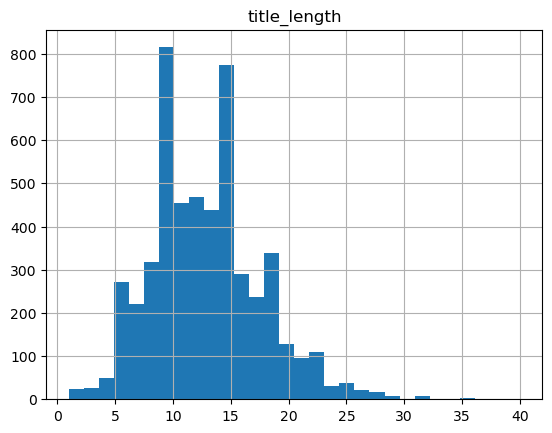

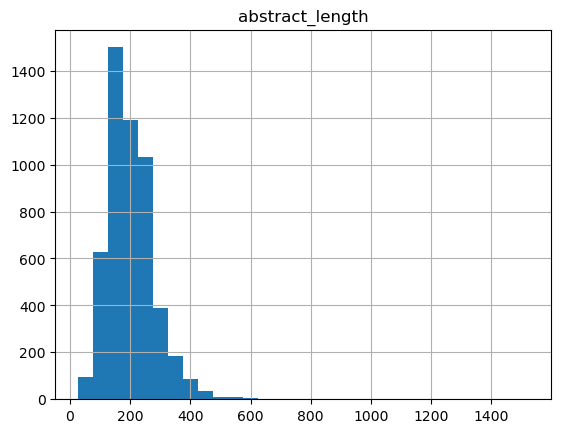

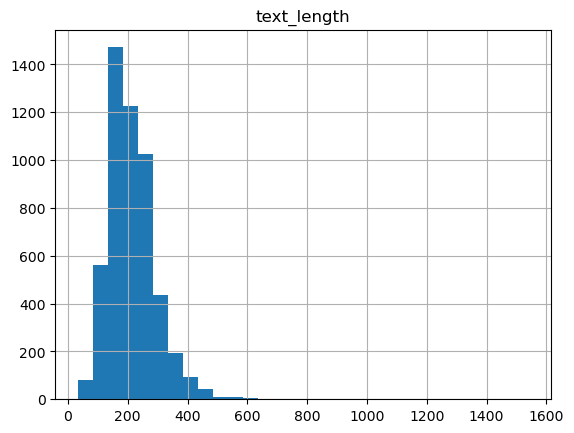

In [14]:
def createHist(df,key):
    # the input is a dataframe and the key being the column to display
    # the output is a histogram
    df.hist(column = key,bins=30)

createHist(df_corpus,'title_length')
createHist(df_corpus,'abstract_length')
createHist(df_corpus,'text_length')

##### 1.2.8 Quelles remarques faites-vous sur les affirmations (claims) et les documents ? (1.5 points) 

En observant les maximums, les minimums et les moyennes, que remarquez-vous à propos des affirmations ('_claims_') ? À l'aide des graphiques générés, comparez également les documents.

**Réponse :**
Les claims ont une longueur moyenne 12 mots, ce qui se rapproche de la moyenne des longueur des titres. Cependant la longueur des abstract est en moyenne bien plus grande. 

In [15]:
# TODO
# end TODO

#### 1.3 Pré-traitement (6 points)
Les affirmations et résumés de texte de votre ensemble de données doivent d’abord être représentés et indexés pour ensuite pouvoir effectuer une recherche de document (pouvant être "_title_", "_abstract_" ou la fusion des deux représentée par "_text_") qui justifie/contredit une affirmation. Vous devez donc implémenter une étape de pré-traitement des données.

##### 1.3.1 Implémentation de la fonction "_tokenize_sentence_" (1 point)

Implémentez la fonction "_tokenize_sentence_" pour la segmentation d'une phrase en une liste de jetons. Utilisez la librarie `nltk`.

In [16]:
def tokenize_sentence(sentence):
    #nltk.tokenize
    return word_tokenize(sentence)

##### 1.3.2 Implémentation de la fonction "_tokenize_text_" (1 point)
Implémentez la fonction "_tokenize_text_" qui utilise "_tokenize_sentence_" pour faire la segmentation d'un texte (liste de phrases).

In [17]:
def tokenize_text(text):
    # takes in a string representing a text (multiple sentences)
    # break it into sentences :
    sentences = nltk.sent_tokenize(text)
    tokenizedText = [tokenize_sentence(sentence) for sentence in sentences]
    return tokenizedText

##### 1.3.3 Implémentation de la fonction "_stem_tokens_" (1 point)

Implémentez la fonction "_stem_tokens_" qui prend une liste de jetons (tokens) en entrée et retourne une liste contenant leur forme racinisée (stems) en utilisant l'algorithme de racinisation PorterStemmer de la bibliothèque nltk.

In [18]:
def stem_tokens(tokenList):
    ps = PorterStemmer()
    return [ps.stem(w) for w in tokenList]

##### 1.3.4 Pré-traitement (2 points)

En utilisant vos précédentes fonctions, faites maintenant le pré-traitement des champs "_text_", "_title_" et "_abstract_" du dataframe "_df_corpus_" et "_claim_" du dataframe "_df_claims_" en suivant les étapes suivantes:
- conversion en minuscules
- segmentation (tokenization) des passages
- suppression des stop-words et ponctuation
- racinisation (stemming) des jetons

Nommez la liste des affirmations pré-traitées par "_claims_preprocessed_". Pour le corpus de documents considérez les ensembles de titres "_title_", de résumés "abstract" et la fusion des deux "_text_" et nommez les listes correspondantes par "_titles_preprocessed_", "_abstracts_preprocessed_" et "_texts_preprocessed_" respectivement.

In [19]:

def preprocess(text):
    # takes in a text to pre-process
    # Convert text to lower case caracters
    text = text.lower()
    # tokenize the text
    text = tokenize_text(text)  # text is now a list of sentences, each sentence is a list of tokens
    # Looping through sentences :
    for i in range(len(text)):
        # Remove stop workds and Stem
        text[i] = [w for w in text[i] if w not in stop_words]
        # Stem
        text[i] = stem_tokens(text[i])
        # Remove punctuation
        text[i] = [w for w in text[i] if w not in punctuation]
    return text

In [20]:
df_claims['claims_preprocessed'] = df_claims['claim'].apply(preprocess)

df_corpus['title_preprocessed'] = df_corpus['title'].apply(preprocess)
df_corpus['abstract_preprocessed'] = df_corpus['abstract'].apply(preprocess)
df_corpus['texts_preprocessed'] = df_corpus['text'].apply(preprocess)

##### 1.3.5 Jetons uniques (types) (1 point)

Affichez maintenant le nombre total de jetons dans tous les textes (_text_) et affirmations (_claim_) (en les considérant comme un seul corpus) après le pré-traitement. Puis, affichez le nombre de jetons uniques (types) dans les textes (_text_) et les affirmations (_claim_). 

In [21]:
whole_text = []
for text in df_corpus['texts_preprocessed']:
    for sentence in text:
        # add the list of tokens in the vocabulary
        whole_text += sentence

for text in df_claims['claims_preprocessed']:
    for sentence in text:
        whole_text += sentence

vocabulary = set(whole_text)
print(f'Taille du vocabulaire : {len(vocabulary)} types')

Taille du vocabulaire : 45194 types


### 2. Représentation des affirmations et des documents  (45 points)

#### 2.1  Vocabulaire (15 points)

##### 2.1.1 Implémentation de la fonction "_get_vocab_" (3 points)

Implémentez la fonction "_get_vocab_" qui prend une liste de textes composés chacun d'une liste de jetons et retourne un dictionnaire dont les clés sont les jetons uniques et les valeurs sont leur fréquence dans l'ensemble des textes.

In [22]:
def get_vocab(text,printResult = False):
    # create a dictionnary
    d = {}
    # looping through tokens
    for el in text:
        if el not in d.keys():
            d[el] = 0
        # count elements
        d[el] += 1

    if printResult:
        for key in d.keys():
            print(f'{key:<20} : {d[key]:>5}')
    return d


##### 2.1.2 Implémentez la fonction "_show_top_N_types_" (3 points)

Implémentez la fonction "show_top_N_types" qui affiche les N jetons les plus fréquents à partir d'un dictionnaire comme celui retourné par la fonction "_get_vocab_".

La fonction prend deux arguments: le dictionnaire "_dictionary_" et le paramètre "_N_". 

In [23]:
def sortDictionary(d):
    return dict(sorted(d.items(), key=lambda item: -item[1]))

def isSorted(d):
    values = list(d.values())
    lenD = len(values)
    i = 0
    while i+1 < lenD:
        # check if the next item is larger than the current one
        if values[i+1]>= values[i]:
            # if so, it is not sorted
            return False
        i += 1
    return True

def show_top_N_types(d,N = 10, printResult = False):
    # takes in a dictionary binding each token with its frequency in the corpus
    if not isSorted(d):
        d = sortDictionary(d)

    dOut = {}

    dKeys = d.keys()
    NKeys = len(d.keys())
    for key in list(dKeys)[:min(N,NKeys)]:
        dOut[key] = d[key]
        
    if printResult:
        for key in dOut.keys():
             print(f'{key:<20} : {d[key]:>5}')
    return dOut


##### 2.1.3 Construction du vocabulaire (1 point)

Construisez maintenant le vocabulaire pour les affirmations et le corpus de documents à partir des listes "texts_preprocessed" et "claims_preprocessed". 

Ensuite affichez les 15 jetons les plus fréquents ainsi que leur fréquence.

In [24]:
corpus = []
for text in df_corpus["texts_preprocessed"]:
    for sentence in text:
        # add the list of tokens in the vocabulary
        corpus += sentence

for text in df_claims["claims_preprocessed"]:
    for sentence in text:
        # add the list of tokens in the vocabulary
        corpus += sentence
        
vocabularyFrequencies = sortDictionary(get_vocab(corpus))
topNTypes = show_top_N_types(vocabularyFrequencies,15,True)
print(len(vocabularyFrequencies.keys()))

cell                 : 10464
patient              :  4175
activ                :  4145
studi                :  4014
use                  :  3799
express              :  3626
result               :  3213
protein              :  3083
gene                 :  3004
cancer               :  2945
increas              :  2794
associ               :  2659
effect               :  2567
function             :  2515
human                :  2464
45194


Sortie attendue:

```Nombre de types composant le vocabulaire: 45195
Les 15 types les plus fréquents:
('cell', 10464)
('patient', 4175)
('activ', 4145)
('studi', 4014)
('use', 3799)
('express', 3626)
('result', 3213)
('protein', 3083)
('gene', 3004)
('cancer', 2945)
('increas', 2794)
('associ', 2659)
('effect', 2567)
('function', 2515)
('human', 2464)

##### 2.1.4 Implémentation de la fonction "_show_distribution_" (4 points)

Implémentez la fonction "__show_distribution__" qui permet de visualiser la distribution des fréquences des jetons à partir d'un dictionnaire comme celui retourné par la fonction "_get_vocab_", en utilisant un graphique où l'axe des abscisses représente le rang d'un type (après un tri par ordre de fréquence décroissante) et l'axe des ordonnées représente sa fréquence sur une échelle logarithmique.  

Par exemple, le point (10000, 10) voudrait dire que le 10000ème mot le plus fréquent a une fréquence à peu prés egale à 10 dans le vocabulaire.

<>:9: SyntaxWarning: invalid escape sequence '\l'
<>:9: SyntaxWarning: invalid escape sequence '\l'
/var/folders/xs/d90v1vkn16db_7z493h6kwt40000gn/T/ipykernel_14567/4049527018.py:9: SyntaxWarning: invalid escape sequence '\l'
  plt.ylabel('$\log(frequency)$')


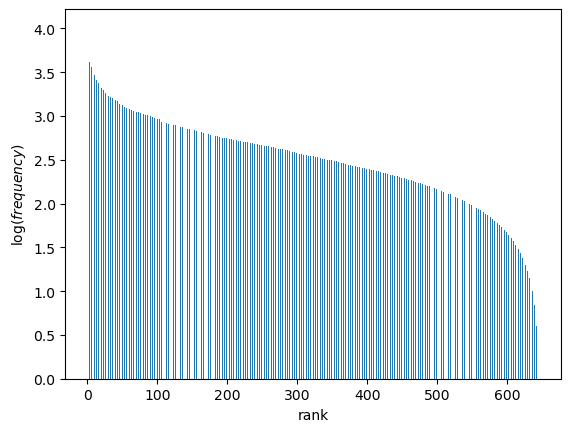

In [25]:
def showDistribution(vocabFrequencies):
    # for two words appearing the same number of times, we consider them the same rank
    setVocabValues = set(vocabFrequencies.values())

    rankDict = {key : rank for rank,key in enumerate(sorted(setVocabValues,reverse = True),1)}
    rankDict = {v: k for k,v in rankDict.items()}

    plt.bar(list(rankDict.keys()),np.log10(list(rankDict.values())),width = .4)
    plt.ylabel('$\log(frequency)$')
    plt.xlabel('rank')
    plt.show()
    return rankDict

rankDict = showDistribution(vocabularyFrequencies)

##### 2.1.5 Vérification de la loi de Zipf (4 points)

Afin de vérifier la loi de Zipf, donnez une estimation de la valeur de la constante k de cette loi définie comme suit: 

$$ f \approx \frac{k}{r^\alpha} $$ 

où $ f $ est la fréquence d'un mot, $ r $ est le rang de ce mot dans la liste triée par fréquence décroissante, et $ k $ est une constante. Etant données les fluctuations sur les valeurs de fréquence, vous pouvez utiliser la librairie ['powerlaw'](https://pypi.org/project/powerlaw/) conçue pour analyser et ajuster des distributions de loi de puissance aux données et qui peut être utile dans l'estimation de $ \alpha $.

Affichez la constante $ k $ trouvée, les fréquences réelles des mots avec celles qui sont prédites par la loi de Zipf.

Calculating best minimal value for power law fit
/opt/miniconda3/envs/generalEnv/lib/python3.12/site-packages/powerlaw.py:699: RuntimeWarning: invalid value encountered in divide
  (CDF_diff**2) /


estimated powerlaw : f = 34949.58615746384 / rank ^3.0499370131037176


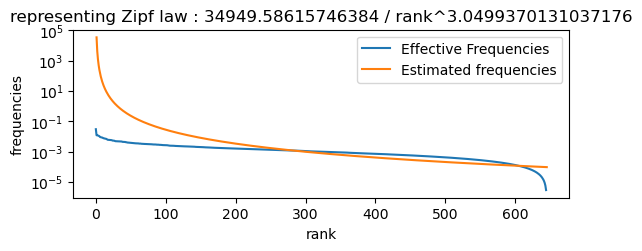

34949.58615746384

In [26]:
# TODO Make sure were talking about frequency as nomber of appearances and not appearances / N_tot

def getZpifK(d,N=20,printResult = False):
    """
    get the dictionnary binding the rank to their frequency
    returns the k constant (freq = k / rank) averaged on N words
    """
    k = []
    
    freq = list(d.values())
    freqTot = sum(freq)
    freq = [f / freqTot for f in freq]

    lenD = len(freq)

    alpha = powerlaw.Fit(freq[:min(lenD,N)]).power_law.alpha

    for i in range(min(lenD,N)):
        k.append(freq[i] * (i**alpha))

    kMean = np.mean(k)

    if printResult:
        print(f'estimated powerlaw : f = {kMean} / rank ^{alpha}')

        fig = plt.figure()
        ax = fig.add_subplot(2, 1, 1)
        ax.plot(freq[:min(lenD,N)],label = "Effective Frequencies")
        ax.plot(range(1,min(lenD,N)+1),[kMean / (i**alpha) for i in range(1,min(lenD,N)+1)],
                 label = "Estimated frequencies")
        ax.set_yscale('log')
        #ax.set_xscale('log')
        plt.legend()

        plt.title(f'representing Zipf law : {kMean} / rank^{alpha}')
        plt.ylabel('frequencies')
        plt.xlabel('rank')
        plt.show()

    return kMean

getZpifK(rankDict,N = len(rankDict.values()),printResult = True)

#### 2.2  Création d’un modèle sac de mots (10 points)

##### 2.2.1 Répresentation de texte (5 points)

En utilisant sklearn et à partir de vos données pré-traitées ("_claims_preprocessed_", "_titles_preprocessed_", "_abstracts_preprocessed_" et "_texts_preprocessed_"), représentez chaque affirmation (_claim_) et document avec le vocabulaire créé 'précédemment dans la variables "_claims_preprocessed_joined", "_titles_preprocessed_joined_", "_abstract_preprocessed_joined_" et "_texts_preprocessed_joined_". Cela veut dire que tout jeton qui n'est pas dans le vocabulaire doit être enlevé dans le document et l'affirmation. Faites cela pour les trois possibilités de représentation de document: "_title_", "_abstract_" et "_text_".

In [27]:
def join(text,vocab = vocabularyFrequencies):
    # Given a vocab, we filter out every token that is not in the vocab
    vocab = vocab.keys()
    outToken = []
    for sentence in text:
        for token in sentence:
            if token in vocab:
                outToken.append(token)
    
    #then we convert the list into a string with a blank space between every token
    outStr = ''
    for token in outToken:
        outStr+= token + ' '
    return outStr[:-1]
                

# As no token is to be removed
df_corpus['title_preprocessed_joined'] = df_corpus['title_preprocessed'].apply(join)
df_corpus['abstract_preprocessed_joined'] = df_corpus['abstract_preprocessed'].apply(join)
df_corpus['texts_preprocessed_joined'] = df_corpus['texts_preprocessed'].apply(join)
df_claims['claims_preprocessed_joined'] = df_claims['claims_preprocessed'].apply(join)

##### 2.2.2 Pondération (4 points)

En utilisant un modèle sac de mots basé sur des unigrammes et des bigrammes, créez une représentation vectorielle de vos documents (titles, abstracts, texts) et de vos affirmations (claims) avec TF-IDF en utilisant le TfidfVectorizer de sklearn. 

In [28]:
# Create a Vectorize object
VECTORIZER = TfidfVectorizer(ngram_range = (1,2))

# Fit on claims and texts
tfidf = VECTORIZER.fit(list(df_claims['claims_preprocessed_joined']) +
                     list(df_corpus['texts_preprocessed_joined'])   )

claimMatrix = tfidf.transform(df_claims['claims_preprocessed_joined'])
titleMatrix = tfidf.transform(df_corpus['title_preprocessed_joined'])
abstractMatrix = tfidf.transform(df_corpus['abstract_preprocessed_joined'])
textMatrix = tfidf.transform(df_corpus['texts_preprocessed_joined'])


##### 2.2.3 Affichage (1 point)

Affichez les dimensions (shape) de vos corpus (claims, text, title, abstract) après vectorisation

In [29]:
print(f'{'':^20}, {'Dimensions':<20}')
print(f'{'claimMatrix':<20}, {str(claimMatrix.shape):<20}')
print(f'{'titleMatrix':<20}, {str(titleMatrix.shape):<20}')
print(f'{'abstractMatrix':<20}, {str(abstractMatrix.shape):<20}')
print(f'{'textMatrix':<20}, {str(textMatrix.shape):<20}')

                    , Dimensions          
claimMatrix         , (809, 473643)       
titleMatrix         , (5183, 473643)      
abstractMatrix      , (5183, 473643)      
textMatrix          , (5183, 473643)      


Sortie attendue pour "_claims_"
```
(809, 473643)
```

Sortie attendue pour "_texts_"
```
(5183, 473643)
```

Sortie attendue pour "_titles_"
```
(5183, 473643)
```

Sortie attendue pour abstracts
```
(5183, 473643)

#### 2.3 Pertinence d'un document (20 points)

Maintenant que vous avez une représentation de vos affirmations "_claims_" et documents ("_texts_", "_titles_", "_abstracts_"), il faut être capable de déterminer quel document sera le plus pertinent pour une affirmation donnée.

##### 2.3.1 Implémentation de "_eval_similarity_" (3 points)

Implémentez la fonction "_eval_similarity_" pour évaluer la similarité cosinus entre la représentation de l'affirmation et celle de chaque document. La fonction prend une liste d'affirmations et une liste de documents et retourne une matrice où chaque ligne représente une affirmation et chaque colonne représente un document ("title", "abstract" ou "text") et les valeurs sont les similarités cosinus entre une affirmation et un document.

In [30]:
def eval_similarity(claimList,docList):
    return cosine_similarity(claimList,docList)

claim_titleSimilarity = eval_similarity(claimMatrix,titleMatrix)
claim_abstractSimilarity = eval_similarity(claimMatrix,abstractMatrix)
claim_textSimilarity = eval_similarity(claimMatrix,textMatrix)

##### 2.3.2 Implémentation de la fonction "_rank_texts_" (2 points)

Implémentez la fonction "_rank_texts_", qui, au moyen de la précédente (_eval_similarity_), retourne le top-N (N=1,3,5) des documents pertinents pour une affirmation donnée (N est un paramètre). Ces documents devront être ordonnés du plus pertinent au moins pertinent. Idéalement, le document à la position 1 sera celui qui contient la preuve (ou justification) de l'affirmation. Il faudra retourner non pas les indices des documents dans le dataframe mais plutôt leur identifiants au niveau de la colonne "_doc_id_".

In [31]:
def rank_texts(similarityMatrix,claimRow,N = 10):
    """
    Takes in the similarity Matrix (row = claim, column = doc)
    returns a vector with the indexes of the N best matches
    """
    indexes = np.argsort(similarityMatrix[claimRow,:])[::-1]
    return indexes[:N]

In [32]:
"""
claim_titleSimilarity[0,rank_texts(claim_titleSimilarity,0,10)]
array([0.05715677, 0.05669945, 0.05557235, 0.05359618, 0.04819043,
       0.04769814, 0.04712101, 0.04404433, 0.04380284, 0.04210753])
"""

'\nclaim_titleSimilarity[0,rank_texts(claim_titleSimilarity,0,10)]\narray([0.05715677, 0.05669945, 0.05557235, 0.05359618, 0.04819043,\n       0.04769814, 0.04712101, 0.04404433, 0.04380284, 0.04210753])\n'

##### 2.3.3 Préparation des dataframes de réponses (1 point) 

Vous allez écrire la fonction "prepare_results_df" qui crée les dataframes qui vont contenir les résultats de la recherche de documents pertinents pour les affirmations.

La fonction "prepare_results_df" prend les arguments suivants:

- '_df_': le dataframe original nommé '_df_claims_' à partir duquel on crée les autres, 
- '_columns_to_drop_': les colonnes à supprimer 
- '_column_to_rename_': le nom de la colonne de référence dans le dataframe original qui sera renommée "gold standard passage"

et effectue les opérations suivantes:

1. Créer un nouveau dataframe à partir de "_df_claims_" en supprimant toutes les colonnes sauf "cited_doc_ids".
2. Renommer la colonne "cited_doc_ids" en "gold standard passage".
3. Ajouter les colonnes "top_1", "top_3", et "top_5" au dataframe, 
en les initialisant avec des chaînes de zéros séparés par des points-
virgules, correspondant respectivement à des configurations de 1, 3, et 
5 zéros pour toutes les lignes.

Vous utiliserez ensuite cette fonction pour créer les dataframes "results_titles_df", "results_abstracts_df" et "results_texts_df", qui seront destinés à contenir les résultats de recherche de documents pour "title", "abstract" et "text" respectivement.

In [33]:
def prepare_results_df(df = df_claims,
                       columns_to_drop = [],
                       columns_to_rename = [('cited_doc_ids','golden_standard_passage')],
                       Ns = [1,3,5]):
    dfOut = pd.DataFrame()
    for key in df.keys():
        if key not in columns_to_drop:
            dfOut[key] = df[key]
    
    for (previousName,newName) in columns_to_rename:
        try:
            dfOut = dfOut.rename(columns={previousName:newName})
        except:
            pass
    
    for N in Ns:
        dfOut[f'top_{N}'] = ('0;' * N)[:-1]

    return dfOut


colToDrop = list(df_claims.keys())
colToDrop.remove('cited_doc_ids')
colToDrop.remove('id')

results_titles_df = prepare_results_df(df = df_claims,
                                       columns_to_drop = colToDrop,
                                       columns_to_rename = [("cited_doc_ids","gold standard passage")])

results_abstracts_df = prepare_results_df(df = df_claims,
                                       columns_to_drop = colToDrop,
                                       columns_to_rename = [("cited_doc_ids","gold standard passage")])

results_texts_df = prepare_results_df(df = df_claims,
                                       columns_to_drop = colToDrop,
                                       columns_to_rename = [("cited_doc_ids","gold standard passage")])
results_texts_df.head()

,id,gold standard passage,top_1,top_3,top_5
0,0,[31715818],0,0;0;0,0;0;0;0;0
1,2,[13734012],0,0;0;0,0;0;0;0;0
2,4,[22942787],0,0;0;0,0;0;0;0;0
3,6,[2613775],0,0;0;0,0;0;0;0;0
4,9,[44265107],0,0;0;0,0;0;0;0;0


> Sortie attendue pour chaque dataframe préparé
<div>
<style scoped>
    .dataframe tbody tr th:only-of-type {
        vertical-align: middle;
    }

    .dataframe tbody tr th {
        vertical-align: top;
    }

    .dataframe thead th {
        text-align: right;
    }
</style>
<table border="1" class="dataframe">
  <thead>
    <tr style="text-align: right;">
      <th></th>
      <th>id</th>
      <th>gold standard passage</th>
      <th>top_1</th>
      <th>top_3</th>
      <th>top_5</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <th>0</th>
      <td>0</td>
      <td>[31715818]</td>
      <td>0</td>
      <td>0;0;0</td>
      <td>0;0;0;0;0</td>
    </tr>
    <tr>
      <th>1</th>
      <td>2</td>
      <td>[13734012]</td>
      <td>0</td>
      <td>0;0;0</td>
      <td>0;0;0;0;0</td>
    </tr>
    <tr>
      <th>2</th>
      <td>4</td>
      <td>[22942787]</td>
      <td>0</td>
      <td>0;0;0</td>
      <td>0;0;0;0;0</td>
    </tr>
  </tbody>
</table>
</div>

##### 2.3.4 Implémentation de la fonction "_fill_results_" (2 points)

Vous devez maintenant implémenter la fonction "_fill_results_" qui remplit les dataframes préparés dans l'étape précédente en utilisant les resultats de recherche de document.
Cette fonction prend les arguments suivant: 
- "_results_" : matrice contenant les valeurs de similarite des affirmations et des documents
- "_results_texts_df_" : Dataframe contenant les affirmations ainsi que les colonnes "top_1", "top_3", "top_5" où doivent être mis les top-n documents les plus pertinents.

Les deux arguments contiennent le même nombre d'éléments et pour le même indice, font référence à la même affirmation.

In [34]:
def fill_results(similarityResultMatrix,resultDataFrame,corpusDataFrame = df_corpus,Ns = [1,3,5]):
    # Repeat for all N
    for N in Ns:
        tempList = []
        # Loop through the lines of the dataframe
        for iRow in range(len(resultDataFrame)):
            # Get the indexes of the most likely document 
            indexes = rank_texts(similarityResultMatrix,iRow,N)
            # Get the id
            ids = list(df_corpus.iloc[indexes]['doc_id'])

            ch = ''
            for id in ids:
                ch += str(id)+';'

            tempList.append(ch[:-1])
        resultDataFrame[f'top_{N}'] = pd.Series(tempList)


##### 2.3.5 Exécution des fonctions "_rank_texts_" et fill_results(2 points)

Exécutez maintenant votre fonction "_rank_texts_" sur toutes les affirmations (claims) et toutes les représentations de documents (title, abstract, text) en mettant les résultats dans les variables "results_texts", "results_titles" et "results_abstracts". Ensuite appelez la fonction "_fill_results_" qui remplit les dataframes "_results_titles_df_", "_results_abstracts_df_", et "_results_texts_df_" contenant les résultats de recheche de documents.

In [35]:
fill_results(claim_titleSimilarity,results_titles_df)
fill_results(claim_abstractSimilarity,results_abstracts_df)
fill_results(claim_textSimilarity,results_texts_df)

In [36]:
results_titles_df

,id,gold standard passage,top_1,top_3,top_5
0,0,[31715818],10029970,10029970;42421723;4459491,10029970;42421723;4459491;25950264;31543713
1,2,[13734012],4828631,4828631;32481310;103007,4828631;32481310;103007;17415081;7020505
2,4,[22942787],10958594,10958594;12074066;24980622,10958594;12074066;24980622;39903312;42731834
3,6,[2613775],2613775,2613775;23117378;21050357,2613775;23117378;21050357;20287253;39381118
4,9,[44265107],44265107,44265107;24700152;14647747,44265107;24700152;14647747;26105746;29366489
...,...,...,...,...,...
804,1403,"[33370, 38355793]",6944800,6944800;33370;24282306,6944800;33370;24282306;13329980;38355793
805,1404,"[33370, 38355793]",32852283,32852283;6944800;33370,32852283;6944800;33370;24282306;13329980
806,1405,[10504681],10504681,10504681;5849439;26378103,10504681;5849439;26378103;435529;7681810
807,1406,[2617858],2617858,2617858;4857085;11419230,2617858;4857085;11419230;27768226;13283919


##### 2.3.6 Enregistrement des dataframes 

On enregistre les dataframes dans des fichiers .csv.

In [37]:
results_titles_df.to_csv('Titles.csv')
results_texts_df.to_csv('Text.csv')
results_abstracts_df.to_csv('Abstract.csv')

##### 2.3.7 Implémentation de la fonction "_show_top_n_passages_" (3 points)

Vous devez maintenant implémenter une fonction "_show_top_n_passages_" qui affiche le top-n ainsi que le texte (document) attendu pour une affirmation donnée. Ici on considère que document est representé par "_text_" donc la fusion du titre ("_title_") et du résumé ("_abstract_")

In [38]:
def show_top_n_passages(resultDataFrame,claimId,df_corpus = df_corpus,N=1):
    # List that will gather the documents
    document = []

    docIds = resultDataFrame[resultDataFrame['id'] == claimId][f'top_{N}'] # string 'Id;Id;Id'
    docIds = list(docIds)[0] # exctract the string inside
    
    listIds = [int(el) for el in docIds.split(sep = ';')]

    for id in listIds:
        print(f'Id : {id}\nText : ')
        document.append(df_corpus[df_corpus['doc_id']==id]['text'])
        print(document[-1])
    
    return document



##### 2.3.8 Affichage (1 point)

Appliquez cette fonction sur l'affirmation ayant pour identifiant 211 et affichez le top-5 des documents les plus pertinents retrouvés.

In [39]:
show_top_n_passages(results_texts_df,211,N = 5)

Id : 14019636
Text : 
2315    Ribosomal DNA copy number loss and sequence va...
Name: text, dtype: object
Id : 44737533
Text : 
4935    Simian immunodeficiency viruses replication dy...
Name: text, dtype: object
Id : 6290112
Text : 
1161    Low copy number of the salivary amylase gene p...
Name: text, dtype: object
Id : 20261352
Text : 
3024    Decoupling activation and exhaustion of B cell...
Name: text, dtype: object
Id : 5137019
Text : 
974    Suppressor of cytokine signaling 3 inhibits an...
Name: text, dtype: object


[2315    Ribosomal DNA copy number loss and sequence va...
 Name: text, dtype: object,
 4935    Simian immunodeficiency viruses replication dy...
 Name: text, dtype: object,
 1161    Low copy number of the salivary amylase gene p...
 Name: text, dtype: object,
 3024    Decoupling activation and exhaustion of B cell...
 Name: text, dtype: object,
 974    Suppressor of cytokine signaling 3 inhibits an...
 Name: text, dtype: object]

##### 2.3.9 Évaluation (3 points)

Vous devez maintenant implémenter la fonction "_evaluate_" qui, à partir des colonnes *Gold standard passage* et de vos top-N respectifs, calcule la précision top-N (N=1,3,5) sur l’ensemble de données en paramètre et l’affiche. 

Cette précision connue sous le nom "precision at k (precision@k)" se calcule de la manière suivante:


$$
\text{precision@k} = \frac{\text{nombre d'éléments corrects}}{\text{nombre total d'éléments k retrouvés}}
$$


Veillez à ce que la fonction soit générique. 

In [40]:
def evaluate(k,resultDataFrame,claimId):
    # Get the gold Standard passage
    GSP = resultDataFrame[resultDataFrame['id'] == claimId]['gold standard passage'] # pd.Series
    GSP = list(GSP)[0] # list of indexes
    
    # Get the top_k
    topK = resultDataFrame[resultDataFrame['id'] == claimId][f'top_{k}'] # pd.Series
    topK = list(topK)[0] # Str
    topK = [int(id) for id in topK.split(';')]
    
    # Evaluate the accuracy 
    nCorrectElement = 0
    for id in topK:
        if id in GSP:
            nCorrectElement += 1

    return nCorrectElement / k

##### 2.3.10 Affichage (1 point)

Appliquez cette fonction pour calculer la précision des documents retrouvés en utilisant les titres ("_title_"), les résumés ("_abstract_") et la fusion des deux ("_text_").

In [41]:
def evaluateAll(resultDataFrame):
    nClaims = len(resultDataFrame)
    kAccuracy = pd.DataFrame({"idClaim": list(resultDataFrame['id']),
                               '1' : np.zeros(nClaims),
                               '3' : np.zeros(nClaims),
                               '5' : np.zeros(nClaims)})
    for k in [1,3,5]:
        lEvaluate = []
        for i in range(nClaims):
            lEvaluate.append(evaluate(k,resultDataFrame,kAccuracy['idClaim'][i]))
        kAccuracy[str(k)] = pd.Series(lEvaluate)
    return kAccuracy

kAccuracyTitle = evaluateAll(results_titles_df)
kAccuracyAbstract = evaluateAll(results_abstracts_df)
kAccuracyText = evaluateAll(results_texts_df)

##### 2.3.11 Graphique (2 points)

Tracez un graphique des valeurs de précisions des documents retrouvés ("__title__", "__abstract__", "__text__") pour différents N (1,3,5).

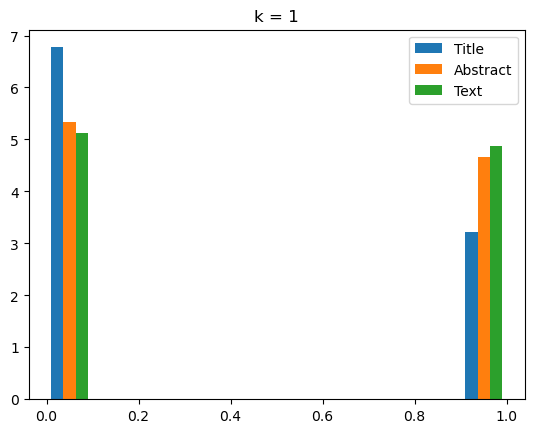

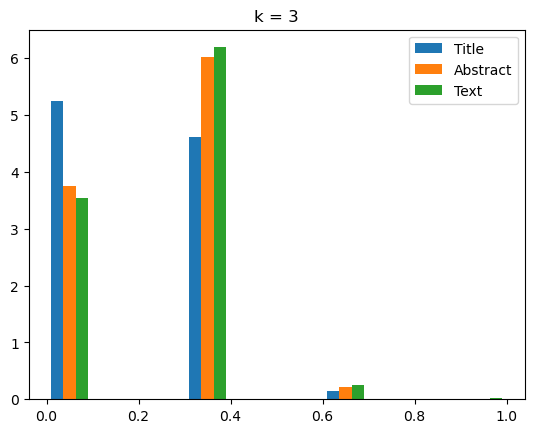

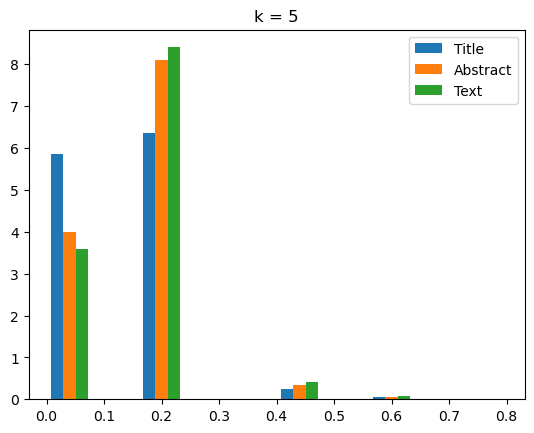

In [42]:
plt.figure()
plt.hist([list(kAccuracyTitle['1']),
          list(kAccuracyAbstract['1']),
          list(kAccuracyText['1'])], density=True, histtype='bar', label=['Title','Abstract','Text'])
plt.legend()
plt.title("k = 1")
plt.show()

plt.figure()
plt.hist([list(kAccuracyTitle['3']),
          list(kAccuracyAbstract['3']),
          list(kAccuracyText['3'])], density=True, histtype='bar', label=['Title','Abstract','Text'])
plt.legend()
plt.title("k = 3")
plt.show()

plt.figure()
plt.hist([list(kAccuracyTitle['5']),
          list(kAccuracyAbstract['5']),
          list(kAccuracyText['5'])], density=True, histtype='bar', label=['Title','Abstract','Text'])
plt.legend()
plt.title("k = 5")
plt.show()

### 3 Amélioration avec BM25 (20 points)

BM25 (Best Matching 25) est un algorithme de recherche utilisé pour évaluer la pertinence des documents par rapport à une requête. Basé sur le modèle de récupération d'informations probabilistes, BM25 calcule un score de pertinence en tenant compte de la fréquence des termes de la requête dans chaque document et dans le corpus global mais aussi de la longueur des documents. 

BM25 est pertinent pour la recherche d'information car il offre un bon équilibre entre précision et rappel, il gère efficacement de grandes collections de documents et permet des ajustements pour différents types de corpus. Il est largement utilisé dans les moteurs de recherche et les systèmes de recommandation.

Dans cette partie on vous demande de la tester au moyen de la librairie rank_bm25 pour cette tâche de recherche de texte qui justifie ou contredit une affirmation donnée. Vous allez utiliser le corpus et les affirmations et procéder comme indiqué dans la suite.

##### 3.1 Initialisation du modèle BM25 (3 points)
Réutilisez les variables "claims_preprocessed_joined", "texts_preprocessed_joined", "titles_preprocessed_joined" et "abstract_preprocessed_joined" définies à la question `2.2.1` pour initialiser les modèles BM25 pour les documents ("__titles__", "__abstracts__" et "__text__"). Il faudra transformer chaque séquence (dont les jetons étaient joints pour former une seule chaîne) en une liste de jetons. Vous utiliserez la classe "_BM250kapi_" à ce niveau. 

In [43]:
claims = [sentence.split(" ") for sentence in df_claims['claims_preprocessed_joined']]
texts = [sentence.split(" ") for sentence in df_corpus['texts_preprocessed_joined']]
abstracts = [sentence.split(" ") for sentence in df_corpus['abstract_preprocessed_joined']]
titles = [sentence.split(" ") for sentence in df_corpus['title_preprocessed_joined']]

In [44]:
texts_bm = BM25Okapi(texts)
abstract_bm = BM25Okapi(texts)
titles_bm = BM25Okapi(titles)

##### 3.2 Utilisation du modèle BM25 (5 points)

Retrouvez les identifiants des documents pour les cinq meilleures correspondances de "_title_", de "_abstract_" et de "_text_" en utilisant le score BM25 pour chaque affirmation (claim) traitée, et mettez à jour les résultats avec les identifiants de documents correspondants.

In [45]:
results_titles_df_BM = prepare_results_df(df = df_claims,
                                       columns_to_drop = colToDrop,
                                       columns_to_rename = [("cited_doc_ids","gold standard passage")])

results_abstracts_df_BM = prepare_results_df(df = df_claims,
                                       columns_to_drop = colToDrop,
                                       columns_to_rename = [("cited_doc_ids","gold standard passage")])

results_texts_df_BM = prepare_results_df(df = df_claims,
                                       columns_to_drop = colToDrop,
                                       columns_to_rename = [("cited_doc_ids","gold standard passage")])

In [69]:
def evaluateBM(bmObject,resultDataFrame,df_claims = df_claims,df_corpus = df_corpus,Ns = [1,3,5]):
    for k in Ns:
        lEvaluate = []
        for i in range(len(resultDataFrame)):

            bmEvaluation = bmObject.get_scores(df_claims['claims_preprocessed_joined'][i]) # np.array
            idx = np.argsort(bmEvaluation)[::-1][:k]

            ch = ''
            for i in idx : 
                ch += str(df_corpus.iloc[i]['doc_id']) + ';'
            lEvaluate.append(ch[:-1])

        resultDataFrame[f'top_{k}'] = pd.Series(lEvaluate)
    

evaluateBM(texts_bm,results_texts_df_BM)
evaluateBM(titles_bm,results_titles_df_BM)
evaluateBM(abstract_bm,results_abstracts_df_BM)


In [70]:
results_texts_df_BM

,id,gold standard passage,top_1,top_3,top_5
0,0,[31715818],24443043,24443043;12009265;4442799,24443043;12009265;4442799;6718824;25300664
1,2,[13734012],7227763,7227763;24443043;4442799,7227763;24443043;4442799;21063817;25300664
2,4,[22942787],12009265,12009265;24443043;39174007,12009265;24443043;39174007;6718824;12443371
3,6,[2613775],24443043,24443043;12443371;341324,24443043;12443371;341324;12009265;4442799
4,9,[44265107],24443043,24443043;341324;4442799,24443043;341324;4442799;25300664;6718824
...,...,...,...,...,...
804,1403,"[33370, 38355793]",24443043,24443043;6718824;341324,24443043;6718824;341324;21063817;4442799
805,1404,"[33370, 38355793]",21063817,21063817;24443043;4442799,21063817;24443043;4442799;25300664;6718824
806,1405,[10504681],24443043,24443043;341324;6718824,24443043;341324;6718824;2575938;24660385
807,1406,[2617858],24443043,24443043;21063817;12009265,24443043;21063817;12009265;341324;6718824


##### 3.3 Affichage des performances (4 points)

Affichez les résultats des performances BM25 pour les configurations Top1, Top3 et Top5 avec "_title_", "_asbtract_" et "_text_".

In [71]:
kAccuracyTitleBM = evaluateAll(results_titles_df_BM)
kAccuracyAbstractBM = evaluateAll(results_abstracts_df_BM)
kAccuracyTextBM = evaluateAll(results_texts_df_BM)

In [72]:
kAccuracyTitleBM

,idClaim,1,3,5
0,0,0.0,0.0,0.0
1,2,0.0,0.0,0.0
2,4,0.0,0.0,0.0
3,6,0.0,0.0,0.0
4,9,0.0,0.0,0.0
...,...,...,...,...
804,1403,0.0,0.0,0.0
805,1404,0.0,0.0,0.0
806,1405,0.0,0.0,0.0
807,1406,0.0,0.0,0.0


##### 3.4 Graphique (4 points)

Dans un même graphique, affichez les performances pour les deux modèles (TF-IDF et BM25) dans la recherche des documents (text, title et abstract) pour les affirmations.

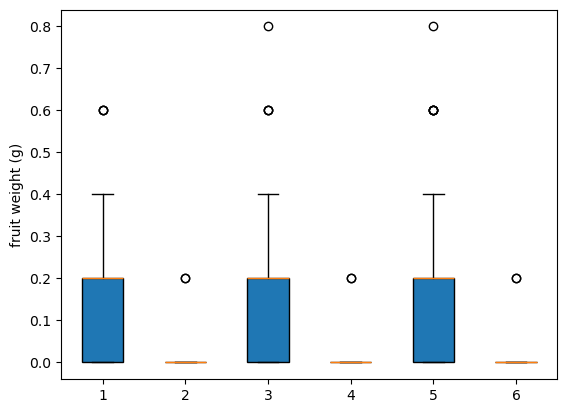

In [73]:
kAccuracy = [kAccuracyTitle['5'],kAccuracyTitleBM['5'],
             kAccuracyAbstract['5'],kAccuracyAbstractBM['5'],
             kAccuracyText['5'],kAccuracyTextBM['5']]
labels = ['TF title','BM Title',
         'TF Abstract','BM Abstract',
         'TF Text','BM Text']

fig, ax = plt.subplots()
ax.set_ylabel('fruit weight (g)')

bplot = ax.boxplot(kAccuracy,
                   patch_artist=True)  # will be used to label x-ticks


plt.show()

##### 3.5 Observation (4 points)

Par rapport à vos résultats avec TF-IDF, observez-vous une amélioration ou une détérioration des performances, qu'est ce qui explique cela ? (Donnez au moins trois justifications)

## Livrables
Vous devez remettre votre notebook sur Moodle et Gradescope en ipynb et pdf. Pour Gradescope vous devez associer les numéros de questions avec vos réponses dans le pdf grâce à l'outil que fournit Gradescope.


## Évaluation 
Votre TP sera évalué selon les critères suivants :
1. Exécution correcte du code et obtention des sorties attendues
2. Réponses correctes aux questions d'analyse
3. Qualité du code (noms significatifs, structure, performance, gestion d’exception, etc.)
4. Commentaires clairs et informatifs
